# FFT of Ricker Wavelet

## Defintions

Fourier transform is defined as 
 $$\large F(\omega)= \mathscr{F}f(t)=\int_{-\infty}^{\infty}e^{-i \omega t}dt$$ 

and inverse Fourier transform is defined as 
$$\large f(t)= \mathscr{F}^{-1}F(\omega)=\frac{1}{2\pi}\int_{-\infty}^{\infty}F(\omega)e^{i \omega t}d\omega$$

The above defitions are referred as the *normal convention of FFT*  hereafter.

For discrete inverve Fourier transform, it is scaled by the number of samples N. 

Let $\large \Delta\omega = 2\pi /N, \omega_m = m\Delta\omega, z_m=e^{2\pi i m/N}=e^{i\omega_m}$
$$ \large F[m]=\mathscr{F}f = \sum_{n=0}^{N-1}f[n]z_m^{-n}$$

$$ \large f[m]=\mathscr{F}^{-1}F = \frac{1}{N}\sum_{n=0}^{N-1}F[n]z_m^{n}$$

Scale factor of FFT and iFFT in numpy are reversed from the normal convention. Hence *np.fft.fft* **should be scaled by $1/N$;** and *np.fft.ifft* **should be scaled by $N$.** See the numpy FFT convention test below. **If using np.fft.ifft for forward transform, the amplitude is not affected but phase is reversed**; positive linear phase from the ouput means time delay in this case.



## Ricker wavelet
Ricker wavelet in time domain (as known as Mexican hat operator)

$$\large Ricker_t(t) = \big(1 -2 (\pi f_c t)^2\big)e^{-(\pi f_c t)^2}$$

Ricker wavelet in frequency domain $$\large Ricker_f(f) = \frac{2f^2}{\sqrt{\pi}f_c^3}e^{-\frac{f^2}{f_c^2}}$$

## FFT in Numpy

Note
* np.fft.fft should be scaled by N; and np.fft.ifft should be scaled by 1/N.
* If using np.fft.ifft for forward transform, the amplitude is not affected but phase is reversed (positive linear phase means time delay).
* Negative time is needed in order to get the Ricker wavelet in time domain. 
* Without applying *np.roll*, the wavelet is delayed by a half cycle. 
* The frequency output array is order as $[0, f_{Nq}], (-f_{Nq}, 0)$. 
* Phase needs to be unwrapped (*np.unwrap*) before plotting.
* To get a zero phase output, $Ricker(t)$ is ordered as $[0 : T_{1/2}], (-T_{1/2}, 0)$ before applying FFT. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt


class ricker_fft:
    def __init__(self, N=1024, fc=50., tmax=1., zerophase=False):
        """
        $\int e^(-iwt) dt$ as Fourier transform (normal convention);
        the numpy function is np.fft.fft and output is scaled by 1/N
        :param N: int, nubmer of samples
        :param fc: float, unit = Hz, central freqency
        :param tmax: float, unit =s, total length of time
        :param zerophase: bool, whether a zero phase wavelet

        """
        fc = float(fc)
        tmax = float(tmax)
        dt = tmax / (N-1)
        df = 1. / tmax
        istart = -N//2 + 1
        nroll = -istart
        t = np.arange(istart, N // 2 + 1) * dt
        f = np.arange(istart, N // 2 + 1) * df
        # arrange f as positve, negative freqs
        f = np.roll(f, -nroll)

        # time domain ricker
        temp = (np.pi * fc * t) ** 2
        ricker_t = (1 - 2 * temp) * np.exp(-temp)

        if zerophase:
            # backward roll ricker_t so that ricker_t[0] corresponds to t=0;
            # otherwise it's delayed a half cycle
            ricker_t = np.roll(ricker_t, -nroll)

        # FFT output is scaled by 1/N to follow the normal convention
        ricker_f = np.fft.fft(ricker_t) / N
        amp = np.absolute(ricker_f)
        phase = np.unwrap(np.angle(ricker_f, False))

        # ricker_f[0] contains the zero frequency term,
        # ricker_f[1:N//2] contains the positive-frequency terms,
        # ricker_f[N//2 + 1:] contains the negative-frequency terms,
        #                     in increasing order starting from the most negative frequency
        self.zerophase = zerophase
        self.fc = fc
        self.dt = dt
        # arange t and ricker_t in the order of increasing time; the zero phase case contains negative time
        if zerophase:
            self.t = t
            self.ricker_t = np.roll(ricker_t, nroll)
        else:
            self.t = t + nroll * dt
            self.ricker_t = ricker_t
        self.f = f
        self.df = df
        self.ricker_f = ricker_f
        self.amp = amp
        self.phase = phase
        self.nroll = nroll


    def test_fft_convention(self):
        t2fMax = max(self.amp)
        theoMax = 2/(np.sqrt(np.pi)*self.fc) * np.exp(-1)
        print('Output from np.fft.fft is scale by 1/{:d}'.format(len(self.t)))
        print('Max amp:\n'
              'theoretical {:g}, scaled discrete FFT {:g}, ratio = {:g}'.format(
               theoMax, t2fMax, t2fMax / theoMax))


    def plot_ricker(self):
        idxNq = len(self.t) // 2
        fig2, ax2 = plt.subplots(1, 3)
        fig2.set_size_inches(18, 6)
        if not self.zerophase:
            tdelay = self.nroll * self.dt
            ax2[0].set_xlim(self.dt * 0.8 * idxNq, self.dt * 1.2 * idxNq)
        else:
            tdelay = 0
            ax2[0].set_xlim(-self.dt * 0.2 * idxNq, self.dt * 0.2 * idxNq)
            ax2[2].set_ylim(-1e-12, 1e-12)
        ax2[0].plot(self.t, self.ricker_t)
        ax2[0].set_title(r'$t_{{delay}}$ = {:.4f} s'.format(tdelay))
        ax2[0].set_xlabel('t (s)')
        ax2[1].plot(self.f[: idxNq + 1], self.amp[: idxNq + 1])
        ax2[1].set_xlabel('f (Hz)')
        ax2[1].set_ylabel('Amp')
        ax2[1].set_title(r'Ricker wavelet, $f_c$ = {:g} Hz'.format(self.fc))
        slope = (self.phase[idxNq] - self.phase[0]) / (self.f[idxNq] - self.f[0])
        ax2[2].plot(self.f[: idxNq + 1], self.phase[: idxNq + 1])
        ax2[2].set_xlabel('f (Hz)')
        ax2[2].set_ylabel('Phase (radians)')
        ax2[2].set_title(r'$d\phi/d\omega$ = {:.4f}'.format(slope / (2 * np.pi)))
        plt.show()

## Numpy FFT convention test
Tests below confirm that *np.fft.fft* needs to be scaled by 1/N. Similarly, *np.fft.ifft* should be scaled by N.

In [2]:
rk_normal = ricker_fft()
rk_normal.test_fft_convention()

Output from np.fft.fft is scale by 1/1024
Max amp:
theoretical 0.00830215, scaled discrete FFT 0.00829403, ratio = 0.999022


## Zero phase
To get a zero phase output, $Ricker(t)$ is ordered as $[0 : T_{1/2}], (-T_{1/2}, 0)$ before applying FFT. 

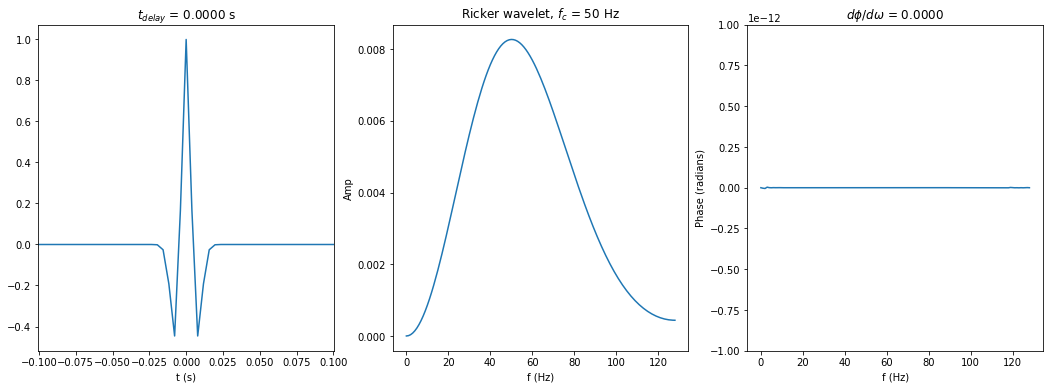

In [3]:
rk2 = ricker_fft(N=256, fc=50., tmax=1., zerophase=True)
rk2.plot_ricker()

## Delayed by a half cycle
Ricker(t)  is ordered as  $(-T_{1/2} : T_{1/2}]$  before applying FFT.

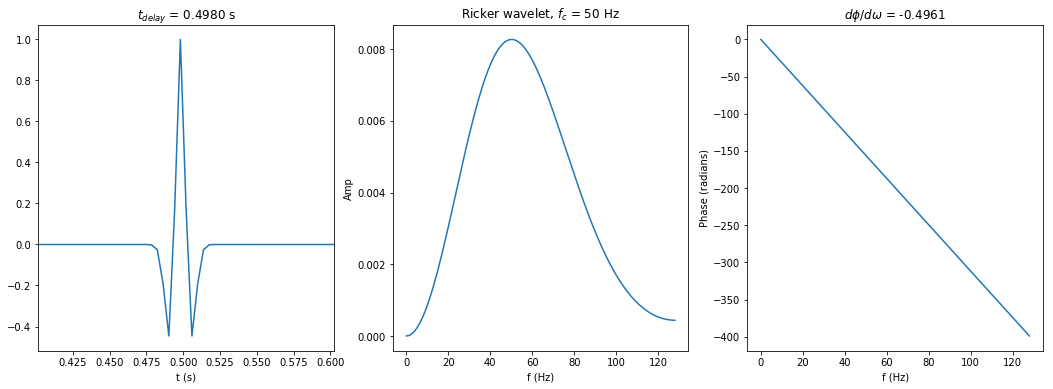

In [4]:
rk1 = ricker_fft(N=256, fc=50., tmax=1., zerophase=False)
rk1.plot_ricker()

# Appendix 1
Derivation of Fourier transform of Ricker wavelet from time doamin to frequncy domain.

Let a Gaussian-like function $g(t)$ be $$ \large g(t) = e^{-(\pi f_c t)^2}$$

It can be shown that $Ricker(t)$ is a scaled version of the second order derivative of the Gaussian function $g(t)$ 
$$ \large Ricker_t(t) = \frac{g''(t)}{-2 (\pi f_c)^2} $$

Hence $$\large Ricker_f(f) = \frac{\omega ^2}{2(\pi f_c)^2} \mathscr{F}g(t) = \frac{2f ^2}{f_c^2} \mathscr{F}g(t)$$

Fourier transform of a Gaussian-like function $g_a(t)=e^{-a^2t^2}$ is derived below
$$ \large G_a(\omega)=\int_{-\infty}^{\infty}e^{-a^2t^2}e^{-i \omega t}dt
=e^{-{\frac{\omega ^2}{4a^2}}}\int_{-\infty}^{\infty}e^{-(at+\frac{i \omega}{2a})^2}dt
= \frac{\sqrt{\pi}}{a}e^{-{\frac{\omega ^2}{4a^2}}} $$

Let $a=\pi f_c$, thus 
$$\large \mathscr{F}g(t) = \frac{1}{\sqrt{\pi}f_c}e^{-\frac{\omega ^2}{4 \pi^2 f_c^2}}$$

Substituting $\omega$ with $2 \pi f$ gives
$$\large Ricker_f(f) = \frac{2f ^2}{f_c^2} \mathscr{F}g(t) = \frac{2f^2}{\sqrt{\pi}f_c^3}e^{-\frac{f^2}{f_c^2}}$$



$$ \large Ricker_{\omega}(\omega) = \frac{4\sqrt{\pi} \omega^2}{\omega_c^3}e^{-\frac{\omega ^2}{\omega_c^2}}$$

# Appendix 2

Discrete inverse Fourier transform of delta function.

Let $\large \Delta\omega = 2\pi /N, \omega_m = m\Delta\omega, z_m=e^{2\pi i m/N}=e^{i\omega_m};\, $ 

hence  
$$ \large z_m^{n}=z_n^{m}, z^N_m=1 $$ 

$$ \large
\begin{equation}
  \sum_{n=0}^{N-1}z_m^{n}=
    \begin{cases}
        1 & m\neq 0 \\
        N & m=0
    \end{cases}
\end{equation}
$$

DFT
$$ \large F[m]=\mathscr{F}f = \sum_{n=0}^{N-1}f[n]z_m^{-n}$$

Invserse DFT
$$ \large f[m]=\mathscr{F}^{-1}F = \frac{1}{N}\sum_{n=0}^{N-1}F[n]z_m^{n}$$

Discrete delta function is 
$$ \large
\begin{equation}
  \vec{\delta_k}[m] =
    \begin{cases}
      1 & m \equiv k \:\text{mod} \:N\\
      0 & \text{otherwise}
    \end{cases}       
\end{equation}
$$

DFT of delta function
$$ \large F[m] = \mathscr{F} \vec{\delta_k} = \sum_{n=0}^{N-1}\vec{\delta_k}[n]z_m^{-n} = z_m^{-k} $$

Invserse DFT
$$ \large f[m] = \mathscr{F}^{-1}z_n^{-k} = \frac{1}{N} \sum_{n=0}^{N-1}z_n^{-k}z_m^{n} = \frac{1}{N} \sum_{n=0}^{N-1}z_n^{m-k} = \vec{\delta_k}[m]$$

